In [129]:
import numpy as np
import scipy.io
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import json

from numpy.lib.stride_tricks import sliding_window_view
from opt_einsum import contract

### Build Connectome DiGraph

In [130]:
def get_connectome(filepath, sheet_name):
    excel_connectome = pd.read_excel(filepath, sheet_name)
    table = excel_connectome.values[1:,2:]

    neuron_names = set().union(table[1:,0], table[0,1:])
    neuron_names = {x for x in neuron_names if x == x} #remove nans
    neuron_names = sorted(list(neuron_names))

    edge_list = []

    def isnan(x):
        return isinstance(x, float) and np.isnan(x)

    for r in range(1,len(table)):
        for c in range(1,len(table[r])):
            if isnan(table[r][c]) or isnan(table[r][0]) or isnan(table[0][c]):
                continue
            edge_list.append((table[r][0], table[0][c], table[r][c]))

    connectome = nx.DiGraph()
    connectome.add_weighted_edges_from(edge_list)  # note that nodes with no edges will not be present in graph
    return connectome

In [131]:
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male chemical")

In [132]:
fake_connectome = get_connectome('datasets/fake_test_data/fake_connectome.xlsx', 'S1S2N1')

In [133]:
class TraceObject:
    def __init__(self, json_filepath):
        with open(json_filepath) as trace_file:
            self.trace_json = json.load(trace_file)
            
        self.num_neurons = self.trace_json['num_neurons']

        self.traces = np.array(self.trace_json['trace_array'])

        self.trace_indices = {}
        for i in range(self.trace_json['num_neurons']):
            if str(i+1) in self.trace_json['labeled']:
                self.trace_indices[self.trace_json['labeled'][str(i+1)]['label']] = i  # neurons are 1-indexed

    def get_label(self, i):
        if str(i+1) not in self.trace_json['labeled']:
            return "" # empty string indicates neuron at index i is unlabeled
        return self.trace_json['labeled'][str(i+1)]['label']
    
    def get_index(self, label):
        if label not in self.trace_indices:
            return -1
        return self.trace_indices[label]
        

In [134]:
def get_relevant_mask(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = set().union([neuron], connectome.successors(neuron), connectome.predecessors(neuron))
    return np.array([trace_obj.get_label(i) in relevant_neurons for i in range(trace_obj.num_neurons)])

In [ ]:
w_rr = 2
w_sr = 1 # must be at most w_rr

In [148]:
def calculate_c(neuron, trace_obj, connectome=CONNECTOME):
    W = trace_obj.traces.shape[1]
    num_windows = W - w_rr + 1

    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)

    # TODO: We incur a T x relevant_count x w_rr x 1 x w_sr (about 2000x) blowup here - there is a LOT of redundancy that might be used to bring this down.
    # relevant_count x w_rr x 1 x w_sr (about 2000) is the number of entries in C
    relevant_sliding_window = np.squeeze(sliding_window_view(trace_obj.traces[relevant_mask,:], (relevant_count, w_rr), writeable=False), axis=0)
    self_sliding_window = np.squeeze(sliding_window_view(trace_obj.traces[self_index:self_index+1,w_rr-w_sr:], (1, w_sr), writeable=False), axis=0)
    self_sliding_window = np.concatenate((np.ones((num_windows, 1, 1)), self_sliding_window), axis=2)
    A = contract("tij,tkl->tijkl", relevant_sliding_window, self_sliding_window).reshape(num_windows, relevant_count * w_rr * (w_sr + 1))
    A = A[:-1,:] # can't predict outside of observation window

    # Looking to minimize Ac - traces[neuron]
    observation = trace_obj.traces[self_index][w_rr:]
    c = np.linalg.inv(A.T @ A) @ A.T @ observation

    plt.plot(np.arange(num_windows-1), observation)
    plt.show()

    plt.plot(np.arange(num_windows-1), A @ c)
    plt.show()

    print(np.linalg.norm(observation - A @ c))

    return c

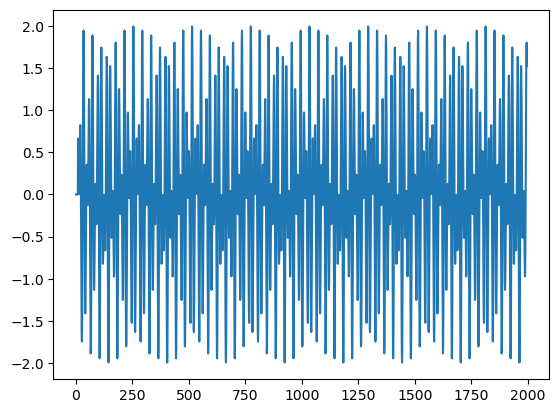

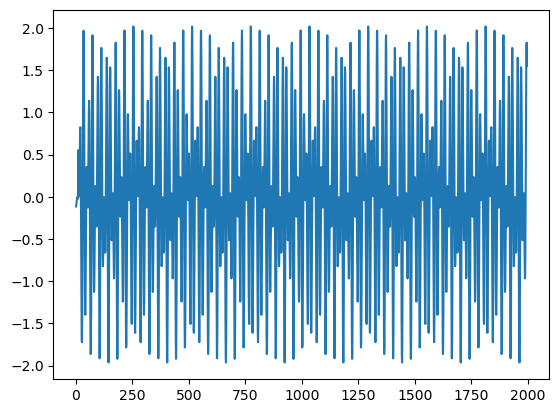

0.9408757792389486
(12,)


In [149]:
trace_obj = TraceObject('datasets/fake_test_data/fake_traces.json')
print(calculate_c('N1', trace_obj, fake_connectome).shape)

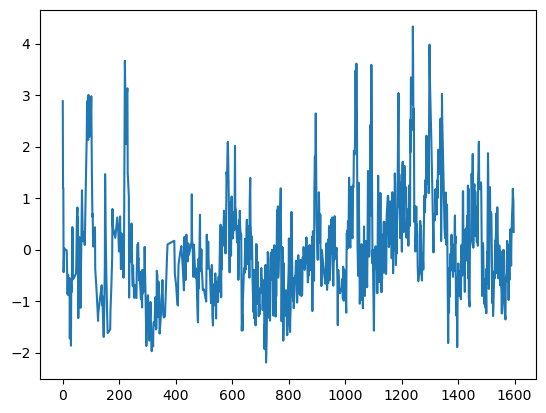

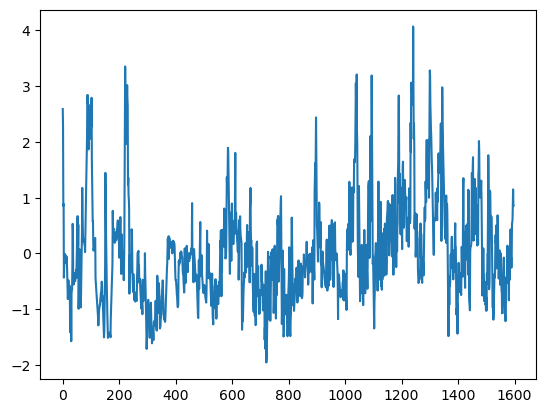

17.317215052240307
(20,)


In [150]:
trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
print(calculate_c('SAADR', trace_obj).shape)

In [154]:
def live_simulation(c, neuron, trace_obj, connectome=CONNECTOME):
    predicted_trace = []
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    
    C = c.reshape((relevant_count,w_rr,1,w_sr+1))

    start = 100
    runtime = 1000
    for t in range(start,start+runtime):
        relevant_history = trace_obj.traces[relevant_mask,t-w_rr:t]
        self_history = trace_obj.traces[self_index:self_index+1,t-w_sr:t]
        augmented_self_history = np.concatenate((np.ones((1,1)), self_history), axis=1)
        predicted_trace.append(contract("ij,ijkl,kl", relevant_history, C, augmented_self_history))

    observation = np.array(trace_obj.traces[self_index,start:start+runtime])
    plt.plot(np.arange(runtime), observation)
    plt.show()

    prediction = np.array(predicted_trace)
    plt.plot(np.arange(runtime), prediction)
    plt.show()

    print(np.linalg.norm(observation - prediction))

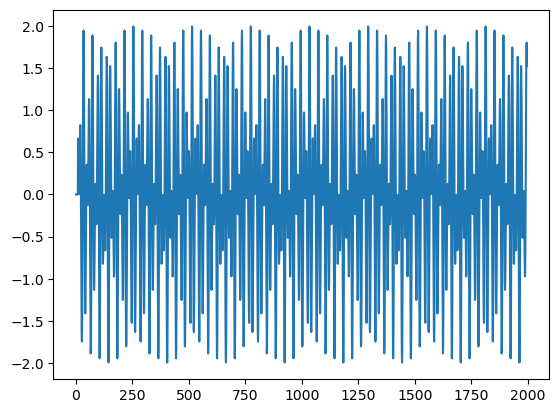

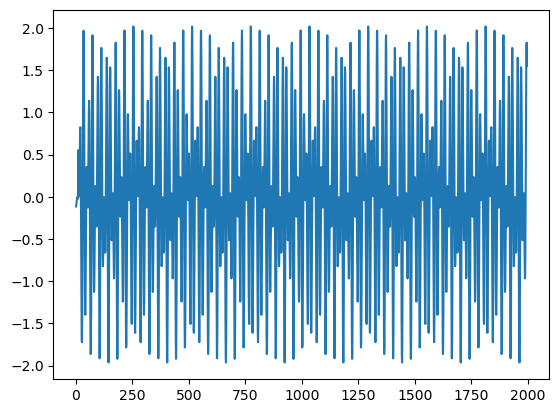

0.9408757792389486


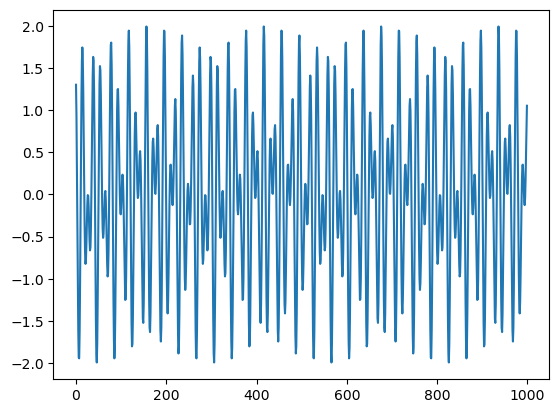

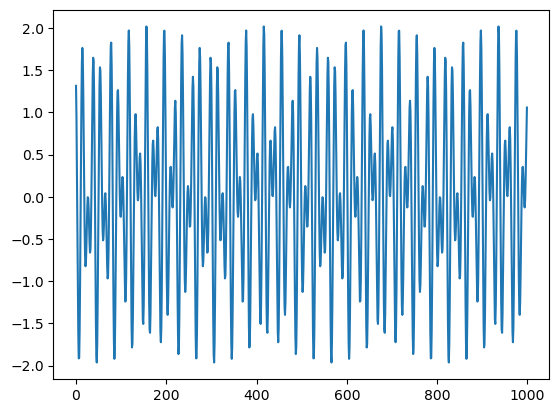

0.4398186175861684


In [155]:
trace_obj = TraceObject('datasets/fake_test_data/fake_traces.json')
c = calculate_c('N1', trace_obj, fake_connectome)
live_simulation(c, 'N1', trace_obj, fake_connectome)

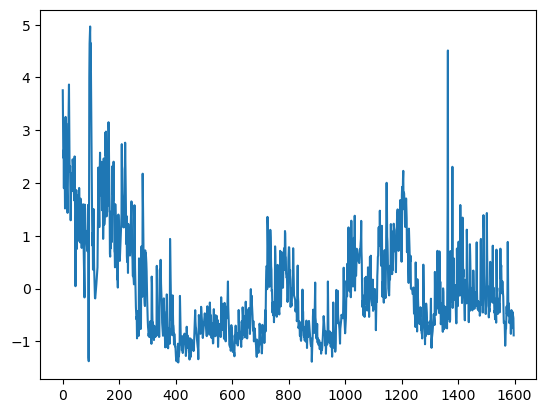

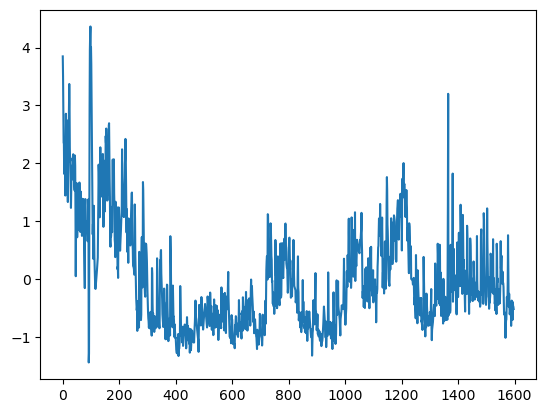

16.344629734066547


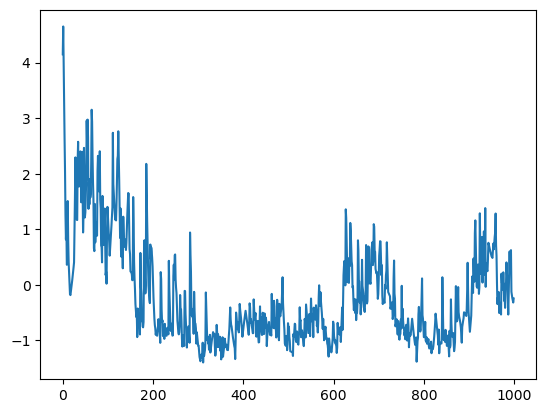

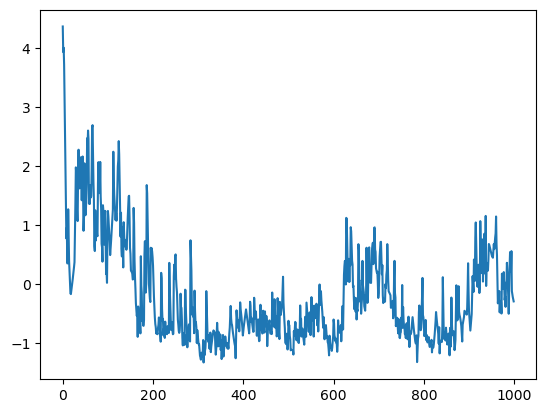

10.611560034463913


In [158]:
trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
c = calculate_c('M5', trace_obj)
live_simulation(c, 'M5', trace_obj)